In [1]:
from timeit import default_timer as timer
from PIL import Image, ImageOps
import numpy as np
import scipy as sc
from scipy import signal
from bm3d import bm3d, BM3DProfile, bm3d_rgb
from SSIM_PIL import compare_ssim

import matplotlib.pyplot as PLT
%matplotlib inline 
#%matplotlib notebook

In [2]:
import multiprocessing
import pyfftw

pyfftw.config.NUM_THREADS = multiprocessing.cpu_count()
pyfftw.config.PLANNER_EFFORT = 'FFTW_MEASURE'

pyfftw.interfaces.cache.enable()
pyfftw.interfaces.cache.set_keepalive_time(10)

def plotNImgs(U, N, txtN=[], shwFlag=True):
    
    if shwFlag is False:
       return
    
    figure, f = PLT.subplots(ncols=N, figsize=(16*N, 16))

    for k in np.arange(N):
        vMin = U[k].min()
        vMax = U[k].max()
        f[k].imshow(Image.fromarray( np.uint8( np.floor( 255*(U[k]-vMin)/(vMax-vMin) ) ) ), cmap='gray')
        if(len(txtN)>0):
            f[k].set_title(txtN[k],fontsize='24')
            f[k].set_axis_off()
    
    return          

def SnPnoise(U,p):
    
    uMax = U.max()
    uMin = U.min()
    
    V = np.zeros(U.shape,dtype=float)
    mask = np.random.binomial(1,1-p,U.shape)
    noise = np.random.binomial(1,0.5,U.shape)
    
    V = U*mask + (1-mask)*noise*uMax +  (1-mask)*(1-noise)*uMin
    
    return V

def gaussNoise(U,sigma):
    
    return (U + np.random.normal(0, sigma, U.shape) )


def saveImg(U,fName):
    vMin = U.min()
    vMax = U.max()
    z = Image.fromarray( np.uint8( np.floor( 255*(U-vMin)/(vMax-vMin) ) ) )
    
    z.save(fName)
    
    return

def snr(Ref, U):
    
    num = np.var( Ref.flatten() )
    den = np.mean( np.abs( Ref.flatten() - U.flatten() )**2 )
    
    return( 10*np.log10(num/den))

def psnr(Ref, U):
    
    num = ( Ref.max() - Ref.min() )**2
    den = np.mean( np.abs( Ref.flatten() - U.flatten() )**2 )
    
    return( 10*np.log10(num/den))

def mse(Ref, U):
    
    return( np.mean( np.abs( Ref.flatten() - U.flatten() )**2 ) )

def ssim(Ref, U):

    vMin = Ref.min()
    vMax = Ref.max()
    charRef = Image.fromarray( np.uint8( np.floor( 255*(Ref-vMin)/(vMax-vMin) ) ) )
    
    vMin = U.min()
    vMax = U.max()
    charU = Image.fromarray( np.uint8( np.floor( 255*(U-vMin)/(vMax-vMin) ) ) )
    
    return( compare_ssim(charRef, charU) )
    
    
def gauss2D(shape=(3,3),sigma=0.5):
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h


def colorConv2d(U, H, boundary='symm', mode='same'):
    nDims = U.shape
    
    V = 0*U
    for k in range( nDims[2] ):
        V[:,:,k] = signal.convolve2d(U[:,:,k], H, boundary=boundary, mode=mode)
    
    return(V)


def conv2D(U, H,  boundary='symm', mode='same'):

    if H.size == 1:  # caso identidad
       return U*H 

    if len(U.shape)==3:
        z = colorConv2d(U, H, boundary=boundary, mode=mode)
    else:
        z = signal.convolve2d(U, H, boundary=boundary, mode=mode)

    return(z)
        
    
def fwOp_Conv(h, Img, vecFlag=False, dims=[]):
        
    if vecFlag:
        Img.shape = dims
        
    if len(Img.shape)==3:
        z = colorConv2d(Img, h, boundary='symm', mode='same').ravel()
    else:
        z = signal.convolve2d(Img, h, boundary='symm', mode='same').ravel()
    
    return z


# # imgs = [ ImageOps.grayscale( Image.open('./testImgs/lena_gray.png') ) ]
# # imgs.append( Image.open('./testImgs/barbara.png')  )
# # imgs.append( ImageOps.grayscale(Image.open('./testImgs/mandrillgr.png')  ))
# # imgs.append( ImageOps.grayscale(Image.open('./testImgs/peppersgray.png'))  )
# imgs = [ Image.open('./testImgs/lena_rgb.png') ]
# imgs.append( Image.open('./testImgs/barbara_rgb.jpg')  )
# imgs.append( Image.open('./testImgs/mandrill.png')  )
# imgs.append( Image.open('./testImgs/Peppers512rgb.png')  )
# u = []

# for k in range(len(imgs)):
#     u.append(np.asarray(imgs[k]).astype(float)/255.)

H = []

H.append( np.ones((1,1)) )             # identidad
H.append( gauss2D((9,9),10.0) )        # Gaussian
H.append( (1./25.)*np.ones((5,5)) )    # Average


def getImg_Fsym(U, nPad):
    
    nU = U.shape

    L = np.floor( (np.asarray(nPad)+0.5)/2 )
    L = L.astype(int)

    if len(nU) == 2:
        uSymm = np.pad(U, ((L[0],L[0]), (L[1],L[1]) ), mode='symmetric') 
        
    if len(nU) == 3:
        uSymm = np.pad(U, ((L[0],L[0]), (L[1],L[1]), (0,0) ), mode='symmetric')
        
    if len(nU) == 4:
        uSymm = np.pad(U, ((L[0],L[0]), (L[1],L[1]), (0,0), (0,0) ), mode='symmetric')
        
    nUsymm = uSymm.shape

    UF = pyfftw.interfaces.numpy_fft.rfft2(uSymm, s=(nUsymm[0]+nPad[0]-1, nUsymm[1]+nPad[1]-1), axes=(0,1))
    
    return UF, nUsymm


def getKernel_Fsym(H, nUsym, shpFlag=True):

    if H.size == 1:
       return H.ravel()
    
    if shpFlag:
       nH = H.shape
       HF = pyfftw.interfaces.numpy_fft.rfft2(H, s=(nUsym[0]+nH[0]-1,nUsym[1]+nH[1]-1), axes=(0,1))
    else:
       HF = pyfftw.interfaces.numpy_fft.rfft2(H, s=(nUsym[0],nUsym[1]), axes=(0,1))
    
    if len(nUsym) == 3: 
        
        HF = np.repeat(HF[..., np.newaxis], 3, axis=-1)
        if len(HF.shape) == 4:
            HF = np.swapaxes(HF,2,3)
        
    return HF

def getROI(Usym, nU, L=np.array([0,0]) ):
           
    if (len(nU))==2:
        z =Usym[ 0+L[0]:nU[0]+L[0], 0+L[1]:nU[1]+L[1] ]
    else:
        z =Usym[ 0+L[0]:nU[0]+L[0], 0+L[1]:nU[1]+L[1], : ]
        
        
        
    return z


def genDxDy_F(nDims, shpFlag=True):
    
    dx = np.zeros((2,2))
    dx[0,0] =  1.
    dx[0,1] = -1.

    dy = np.zeros((2,2))
    dy[0,0] =  1.
    dy[1,0] = -1.
    
    dx = dx[...,np.newaxis]
    dy = dy[...,np.newaxis]
        
    return( getKernel_Fsym(np.concatenate( (dx,dy), axis=-1), nDims, shpFlag) )

In [3]:
imgs = [ ImageOps.grayscale( Image.open('./testImgs/lena_gray.png') ) ]
imgs.append( Image.open('./testImgs/barbara.png')  )
imgs.append( ImageOps.grayscale(Image.open('./testImgs/mandrillgr.png')  ))
imgs.append( ImageOps.grayscale(Image.open('./testImgs/peppersgray.png'))  )
# imgs = [ Image.open('./testImgs/lena_rgb.png') ]

imgs.append( Image.open('./testImgs/lena_rgb.png')  )
imgs.append( Image.open('./testImgs/barbara_rgb.jpg')  )
imgs.append( Image.open('./testImgs/mandrill.png')  )
imgs.append( Image.open('./testImgs/Peppers512rgb.png')  )
u = []

for k in range(len(imgs)):
    u.append(np.asarray(imgs[k]).astype(float)/255.)

In [63]:
def fista_l0tv(b, H, lmb, ePar, nIter=np.array([10,5],dtype=int), beta=1./8., flagSymm=True, flagPCost=True):

    
    Tstart = timer()
    
    tvStats = np.zeros((nIter[0],5), dtype=float)  #  k, cost, L2, TV, timer
    
    bShp = b.shape
    
    if flagSymm:
#        bF, symDims = getImg_Fsym(b, (1,1))
#        HF = getKernel_Fsym(H, symDims, shpFlag=False)
        
#        DF = genDxDy_F(symDims, shpFlag=False)
    
#        L = np.array([0,0],dtype=int)
       bF, symDims = getImg_Fsym(b, H.shape)
       HF = getKernel_Fsym(H, symDims, shpFlag=True)
#        print (symDims)
       L = np.floor( (np.asarray(H.shape)+0.5)/2 )
       L = L.astype(int)
#        print (L)
       if len(symDims)==3:
            L=np.append(L,0)
#        print (symDims+2*L)
       DF = genDxDy_F(symDims+2*L,shpFlag=False)
        
    else:
       bF, symDims = getImg_Fsym(b, H.shape)      # Dx / Dy <--> 2x1 filter (2,2)
       HF = getKernel_Fsym(H, symDims)

       L = np.floor( (np.asarray(H.shape)+0.5)/2 )
       L = L.astype(int)    
    
       DF = genDxDy_F((symDims[0]+H.shape[0]-1,symDims[1]+H.shape[1]-1,symDims[2]),shpFlag=False)
       print (symDims) 
    
    bF_norm = 1.5*np.sum( np.abs( bF )**2.0 )/np.float(b.size) 
    print("bf_norm")
    print(bF_norm)
    # Dx*b, Dy*b

    
    HTH_F = np.conj(HF)*HF 
    DTD_F = np.sum(np.conj(DF)*DF,axis=-1).real
    HTb_F = np.conj(HF)*bF
#     print (HTH_F.shape)
#     print (DTD_F.shape)
#     print (HTb_F.shape)
    
    lmb1 = np.sqrt(2.*ePar*lmb)
    lmb2 = ePar
    
    
    x1_uF = np.zeros( bF.shape, dtype=float)
    y_uF  = x1_uF.copy()
    
    # Outer-loop
    for it in range(nIter[0]):
#         print ("a")
        if it > 0:
            
            # gradient
            nabla0 = HTH_F*y_uF - HTb_F
            nabla = nabla0 - lmb2*DTD_F*y_uF
            
            # FIXME: Cauchy lagged (flag for others)
            if it%2 == 0:
                den0 = HF*nabla
                den1 = np.einsum('ij...k,ij...->ij...k', DF, nabla )
                alpha = np.sum( np.real( np.conj(nabla) * nabla ) ) / (np.sum( np.real( np.conj(den0) * den0 ) ) + np.sum( np.real( np.conj(den1) * den1 ) ))
                        
            #DxDy_BF = np.einsum('ijk,ij->ijk', DF, x1_uF - alpha*nabla )
            DxDy_BF = np.einsum('ij...k,ij...->ij...k', DF, y_uF - alpha*nabla )
            
            x1_PF *= 0.
            y_PF  *= 0.
            
        else:
            
            
            # gradient
            nabla = -HTb_F

            # FIXME: Cauchy (1st step)
            den   = HF*nabla
            alpha = np.sum( np.real( np.conj(nabla) * nabla ) ) / np.sum( np.real( np.conj(den) * den ) )
            
            DxDy_BF = np.einsum('ij...k,ij...->ij...k', DF, -alpha*nabla)
            
            x1_PF = np.zeros( (*bF.shape,2), dtype=float)
            y_PF  = x1_PF.copy()
            
    
        # inner-loop
        for itTV in range(nIter[1]):

            # \nabla 0.5|| hx*p + hy*q - b_k ||_2^2  (in freq)
            DFT_PF = np.einsum('ij...k,ij...k->ij...', np.conj(DF), y_PF)
        
            gF = alpha*lmb1*np.einsum('ij...k,ij...->ij...k', DF, DFT_PF) - DxDy_BF
    
    
            # FISTA step
    
            x0_PF = x1_PF.copy()
    
            x1_PF = y_PF - (beta/(alpha*lmb1))*gF
        
            # normalization step
            x1 = pyfftw.interfaces.numpy_fft.irfft2( x1_PF, axes=(0,1))
        
            mask = np.sqrt(x1[...,0]*x1[...,0] + x1[...,1]*x1[...,1])
    
            x1 = np.einsum('ij...k,ij...->ij...k', x1, 1./np.where(mask>1,mask,1.0))
        
            # back to freq
            if flagSymm:
               x1_PF,dummy = getImg_Fsym(x1, (1,1))
#                x1_PF,dummy = getImg_Fsym(x1, H.shape)
            else:
               x1_PF,dummy = getImg_Fsym(x1, (1,1)) #(2,2)

        
            gammaTV = float(itTV-1)/float(itTV+2)
            
            y_PF = x1_PF + gammaTV*(x1_PF - x0_PF)
            
            if itTV==0 and it==0:
                xfirst_uF = y_uF - alpha*nabla - alpha*lmb1*np.einsum('ij...k,ij...k->ij...', np.conj(DF), y_PF)
                xfnorm=1.5*np.sum( np.abs( HF*xfirst_uF - bF  )**2.0 )/np.float(b.size)
                duxf  =  getROI( pyfftw.interfaces.numpy_fft.irfft2( np.repeat(xfirst_uF[...,np.newaxis],2,-1)*DF, axes=(0,1)),  bShp, L )

                auxi=lmb1*np.sum((np.sqrt(np.sum(duxf**2.0,axis=2))))-(ePar/2.0)*np.sum(np.sum(duxf**2.0,axis=2))
                print(xfnorm+auxi)
        
    
#             # normalization step
#             y = pyfftw.interfaces.numpy_fft.irfft2( y_PF, axes=(0,1))
            
#             mask = np.sqrt(y[...,0]*y[...,0] + y[...,1]*y[...,1])
    
#             y = np.einsum('ij...k,ij...->ij...k', y, 1./np.where(mask>1,mask,1.0))
        
#             # back to freq
#             if flagSymm:
#                y_PF,dummy = getImg_Fsym(y, (1,1))
#             else:
#                y_PF,dummy = getImg_Fsym(y, (2,2))

            
        # (outer) FISTA step
            
        x0_uF = x1_uF.copy()

        x1_uF = y_uF - alpha*nabla - alpha*lmb1*np.einsum('ij...k,ij...k->ij...', np.conj(DF), y_PF)
            
        gamma = float(it-1)/float(it+2)
        
        y_uF = x1_uF + gamma*(x1_uF - x0_uF)
    
        # -----------------
        # Statistics
        
        du  =  getROI( pyfftw.interfaces.numpy_fft.irfft2( np.repeat(x1_uF[...,np.newaxis],2,-1)*DF, axes=(0,1)),  bShp, L )

        #print(np.shape(du))
        tvStats[it,0] = it
        
        #bF_lHF = np.einsum('ijk,ijk->ij', np.conj(DF), y_PF)  # conj(Hx)*pF +conj(Hy)*qF 
        tvStats[it,2] = 1.5*np.sum( np.abs( HF*x1_uF - bF  )**2.0 )/np.float(b.size)     # NOTA: esto es aproximado
        
        #tvStats[it,3] = lmb*np.sum( np.sqrt(np.sum( np.abs( pyfftw.interfaces.numpy_fft.irfft2( np.einsum('ij...k,ij...->ij...k', DF,  x1_uF), axes=(0,1)) ), axis=2 )) > 0.1)
        
        tvStats[it,3] = lmb1*np.sum((np.sqrt(np.sum(du**2.0,axis=2))))-(ePar/2.0)*np.sum(np.sum(du**2.0,axis=2))
        
        tvStats[it,1] = tvStats[it,2] + tvStats[it,3]
        #tvStats[it,1] = tvStats[it,3]
                        
        tvStats[it,4] = timer()-Tstart
                        
        if flagPCost:
            print('QE-l0tv', it, tvStats[it,1], tvStats[it,4])
    
        # -----------------    
    
    
#     u = pyfftw.interfaces.numpy_fft.irfft2( x1_uF, axes=(0,1))
    u =   getROI( pyfftw.interfaces.numpy_fft.irfft2( x1_uF, axes=(0,1) ), bShp, 0*L )
#     print (x1_uF.shape)
#     print (u.shape)
    
    return (u, tvStats)

In [5]:
def shrinkl1TV(v,lmb):

    sq = np.sum(v**2.0, axis=-1, keepdims=True) 
    if len(sq.shape) <= 3:
        sq = np.sqrt(sq)
    else:
        sq = np.sqrt( np.sum(sq,axis=-2, keepdims=True) )
#         sq = np.sum(np.sqrt(sq),axis=-2, keepdims=True) 
    th = np.clip(sq - lmb, 0, float('Inf'))
    
    w =  np.where(sq==0, 0, th)/np.where(sq==0, 1, sq)
    

    return(w*v)

In [69]:
def admmql0(b, H, lmb, gamma , nIter, rhoFactor=10, relax=1.0, flagPCost=True, flagSymm=True):

    
    Tstart = timer()
    
    tvStats = np.zeros((nIter,5), dtype=float)  #  k, cost, L2, TV, timer
    
    bShape = b.shape
    
    if flagSymm:
#        bF, symDims = getImg_Fsym(b, (1,1))
#        HF = getKernel_Fsym(H, symDims, shpFlag=False)
        
#        DF = genDxDy_F(symDims, shpFlag=False)
    
#        L = np.array([0,0],dtype=int)

       bF, symDims = getImg_Fsym(b, H.shape)
       HF = getKernel_Fsym(H, symDims, shpFlag=True)
       
       L = np.floor( (np.asarray(H.shape)+0.5)/2 )
       L = L.astype(int)
       #print (L)
       if len(symDims)==3:
            L=np.append(L,0)
    
       DF = genDxDy_F(symDims+2*L,shpFlag=False)
    
    else:
       bF, symDims = getImg_Fsym(b, H.shape)
       HF = getKernel_Fsym(H, symDims)

       L = np.floor( (np.asarray(H.shape)+0.5)/2 )
       L = L.astype(int)    
    
       DF = genDxDy_F(symDims)
        
#     print ("bf "+str(bF.shape))
#     print ("Symdims "+str(symDims))
#     print ("Hf "+str(HF.shape))
#     print ("DF "+str(DF.shape))
    
    bF_norm = 1.5*np.sum( np.abs( bF )**2.0 )/np.float(b.size) 
#     print("bf_norm")
#     print(bF_norm)

    # Init Z
    z = np.zeros( (*bShape,2), dtype=float)
    
    # Init C
    c = np.zeros( (*bShape, 2), dtype=float)
    
    #rho = rhoFactor*lmb + 0.1
    rho = rhoFactor
       
    HTH_F = np.conj(HF)*HF 
    DTD_F = np.sum(np.conj(DF)*DF,axis=-1).real
    HTb_F = np.conj(HF)*bF
    
    
    cost = []
    
    par=np.sqrt(2.0*gamma*lmb)
    par_1=np.sqrt(2.0*gamma*lmb)/rho
    
#     bF_H=bF/HF
#     db  =  getROI( pyfftw.interfaces.numpy_fft.irfft2( (np.repeat(bF[...,np.newaxis],2,-1)*DF), axes=(0,1)),  bShape, L )
#     #bnorm=1.5*np.sum( np.abs( HF*bF - bF  )**2.0 )/np.float(b.size)
#     db_grad=par*np.sum((np.sqrt(np.sum(db**2.0,axis=2))))-(gamma/2.0)*np.sum(np.sum(db**2.0,axis=2))
#     it0=db_grad#+bnorm
#     print (it0)
    
    for it in range(nIter):
        
        
        # Tikhonov sub-problem
        if flagSymm:
           #zcSubs,dummy = getImg_Fsym(z-c, (1,1))
           zcSubs,dummy = getImg_Fsym(z-c, H.shape)
        else:
           zcSubs,dummy = getImg_Fsym(z-c, H.shape)
        
#         print ("zcSubs"+str(np.shape(zcSubs)))
        
        DTzc_F = np.einsum('ij...k,ij...k->ij...', np.conj(DF), zcSubs)
#         DTzc_F = np.sum(np.conj(DF)*zcSubs, axis=-1)
#         print ("DTzc_f"+str(np.shape(DTzc_F)))
        
        uF = (( HTb_F + rho*DTzc_F )/( HTH_F + (rho-gamma)*DTD_F))
            
        du  =  getROI( pyfftw.interfaces.numpy_fft.irfft2( (np.repeat(uF[...,np.newaxis],2,-1)*DF), axes=(0,1)),  bShape, L )
        
        
        # Prox op (NOTA: pasar como ptr --> ADMM generico )
        z0=z
        z = shrinkl1TV( relax*du + (1-relax)*z + c, par_1)
        c += relax*du + (1-relax)*z0-z
        
                
        
        
#         if np.abs(relax-1.0) > 0.01:
#             z0=z
#             z = shrinkl1TV( relax*du + (1-relax)*z + c, par_1)
#             c += relax*du + (1-relax)*z0-z
#         else:
#             z = shrinkl1TV( du + c, par_1)
#             c += du - z
        # actualiza c
        #c += du - z

        # -----------------
        # Statistics
        tvStats[it,0] = it
                        
#         tvStats[it,2] = 1.5*np.sum( np.abs(HF*uF - bF)**2.0 )/np.float(b.size)     # NOTA: esto es aproximado
        
#         tvStats[it,3] = np.sum( np.sum(np.abs(du),axis=2) > 0.01 )
        
#         tvStats[it,1] = tvStats[it,2] + lmb*tvStats[it,3]
        
        
        tvStats[it,2] = 1.5*np.sum( np.abs( HF*uF - bF  )**2.0 )/np.float(b.size)     # NOTA: esto es aproximado
        
        
        tvStats[it,3] = par*np.sum((np.sqrt(np.sum(du**2.0,axis=2))))-(gamma/2.0)*np.sum(np.sum(du**2.0,axis=2))
        
        #tvStats[it,3] = lmb*np.sum( np.sqrt(np.sum( np.abs( pyfftw.interfaces.numpy_fft.irfft2( np.einsum('ij...k,ij...->ij...k', DF,  uF), axes=(0,1)) ), axis=2 )) > 0.1)
        
        tvStats[it,1] = tvStats[it,2] + tvStats[it,3]
        
        
        tvStats[it,4] = timer()-Tstart
                        
        if flagPCost:
            print('l0tv', it, tvStats[it,1], tvStats[it,4])
    
        # -----------------    
    
    u =   getROI( pyfftw.interfaces.numpy_fft.irfft2( uF, axes=(0,1) ), bShape, 0*L )
#     u=pyfftw.interfaces.numpy_fft.irfft2( uF, axes=(0,1) )
    
    return(u, tvStats)

In [7]:
Names=["Lgr","Bgr","Mgr","Pgr","Lc","Bc","Mc","Pc"]

## denoising

In [44]:
lmb_Ql0grad_grey=[0.06874999999999999,0.031249999999999993,0.021250000000000005,0.07687500000000001,
                 0.36,0.18791666666666668, 0.15,0.3804166666666666,
                 3.0972222222222223,2.5555555555555554,1.902777777777778,3.138888888888889,
                 14.472222222222221,14.180555555555555,14.069444444444445,14.763888888888888]

lmb_Ql0grad_color=[0.06250000000000001,0.039375,0.019375,0.06562500000000002,
                  0.34375,0.2625,0.14375000000000002,0.375,
                  3.083333333333333,2.722222222222222,2.0555555555555554,3.027777777777778,
                  14.833333333333334,14.111111111111112,12.36111111111111,14.833333333333334]  

bf_norm
106173.62936143398
19511.114252105457
26136.333400063544


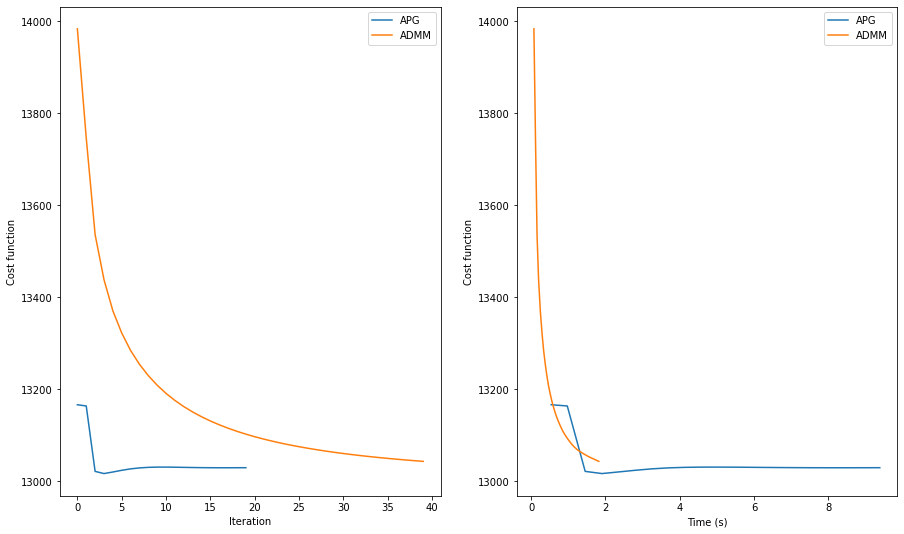

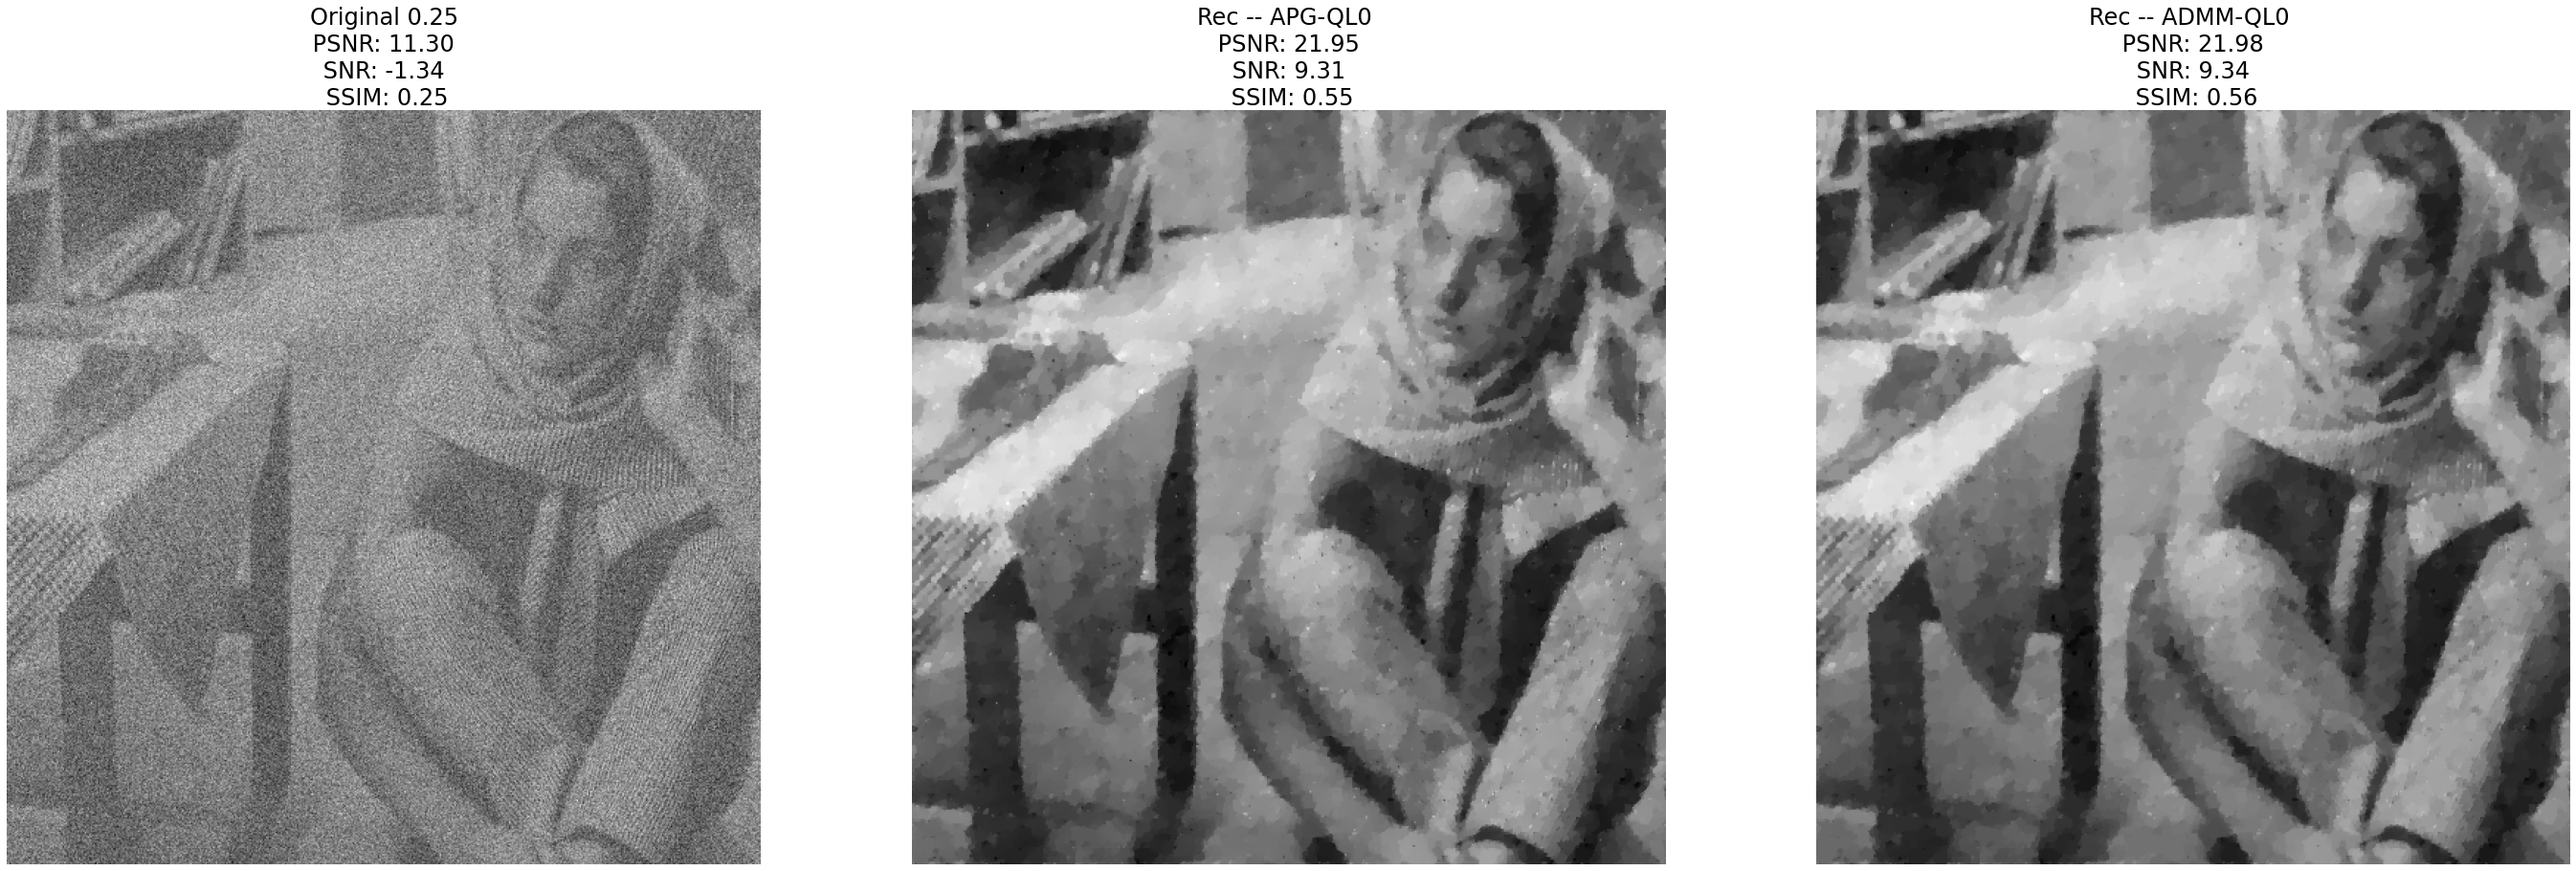

In [66]:
#sigma
j=2
#image
k=1

sigmas=[0.05,0.1,0.25,0.5]
sigstr=["005","01","025","05"]
sig=sigmas[j]
imgBlur=gaussNoise( conv2D(u[k], H[0] ), sig )  
imgRec_Ql0grad, Stats_Ql0grad = fista_l0tv(imgBlur, H[0], lmb_Ql0grad_grey[k+j*4], 0.01, nIter=np.array([20,20],dtype=int), beta=1./8., flagSymm=True, flagPCost=False) 
imgRec_Ql0grad_admm, Stats_Ql0grad_admm = admmql0(imgBlur, H[0], lmb_Ql0grad_grey[k+j*4], 0.01,40, rhoFactor=20, relax=1.5, flagPCost=False, flagSymm=True) 


# k=k-4
# imgRec_Ql0grad, Stats_Ql0grad = fista_l0tv(imgBlur, H[0], lmb_Ql0grad_color[k+j*4], 0.04, nIter=np.array([20,20],dtype=int), beta=1./8., flagSymm=True, flagPCost=False) 
# imgRec_Ql0grad_admm, Stats_Ql0grad_admm = admmql0(imgBlur, H[0], lmb_Ql0grad_color[k+j*4], 0.04,40, rhoFactor=20, relax=1.5, flagPCost=False, flagSymm=True) 


#admmql0(b, H, lmb, gamma , nIter, rhoFactor=10, relax=1.0, flagPCost=True, flagSymm=True):


imgRec_Ql0grad=np.clip(imgRec_Ql0grad,0,1)
imgRec_Ql0grad_admm=np.clip(imgRec_Ql0grad_admm,0,1)

#plot cost function
# k=k+4
# Plot TV-fCost
figure, f = PLT.subplots(ncols=2, figsize=(15, 9))

f[0].plot(Stats_Ql0grad[:,0], Stats_Ql0grad[:,1],label="APG")
f[0].plot(Stats_Ql0grad_admm[:,0], Stats_Ql0grad_admm[:,1],label="ADMM")
f[0].legend(loc='upper right')
PLT.setp(f[0], xlabel='Iteration',ylabel='Cost function')

f[1].plot(Stats_Ql0grad[:,4], Stats_Ql0grad[:,1],label="APG")
f[1].plot(Stats_Ql0grad_admm[:,4], Stats_Ql0grad_admm[:,1],label="ADMM")
f[1].legend(loc='upper right')
PLT.setp(f[1], xlabel='Time (s)',ylabel='Cost function')
# PLT.savefig("./comparison_admm_apg/"+Names[k]+"004denois.svg")

PLT.show()


# print ("Time in APG= "+str(Stats_Ql0grad[19,4])+"\n")
# print ("Time in APG= "+str(Stats_Ql0grad_admm[39,4]))


metrics_TV = []

metrics_TV.append( psnr(u[k], imgBlur) )
metrics_TV.append(  snr(u[k], imgBlur) )
metrics_TV.append( ssim(u[k], imgBlur) )

metrics_TV.append( psnr(u[k], imgRec_Ql0grad) )
metrics_TV.append(  snr(u[k], imgRec_Ql0grad) )
metrics_TV.append( ssim(u[k], imgRec_Ql0grad) )

metrics_TV.append( psnr(u[k], imgRec_Ql0grad_admm) )
metrics_TV.append(  snr(u[k], imgRec_Ql0grad_admm) )
metrics_TV.append( ssim(u[k], imgRec_Ql0grad_admm) )


                  
# \n PSNR: {:01.2f} \n SNR: {:01.2f} \n MSE: {:01.2g} \n SSIM: {:01.2f}'.format(metrics_TV[4],metrics_TV[5],metrics_TV[6],metrics_TV[7]))
                  

txtN = []
txtN.append('Original '+str(sig)+'\n PSNR: {:01.2f} \n SNR: {:01.2f} \n SSIM: {:01.2f}'.format(metrics_TV[0],metrics_TV[1],metrics_TV[2]))
txtN.append('Rec -- APG-QL0 \n PSNR: {:01.2f} \n SNR: {:01.2f} \n SSIM: {:01.2f}'.format(metrics_TV[3],metrics_TV[4],metrics_TV[5]))
txtN.append('Rec -- ADMM-QL0 \n PSNR: {:01.2f} \n SNR: {:01.2f} \n SSIM: {:01.2f}'.format(metrics_TV[6],metrics_TV[7],metrics_TV[8]))


imgShow = []
imgShow.append(imgBlur)
imgShow.append(imgRec_Ql0grad)
imgShow.append(imgRec_Ql0grad_admm)



plotNImgs(imgShow, 3, txtN)  

# # saveImg(imgBlur,"./comparison_admm_apg/"+Names[k]+sigstr[j]+"den.png")
# saveImg(imgRec_Ql0grad,"./comparison_admm_apg/"+Names[k]+sigstr[j]+"004denapg.png")
# saveImg(imgRec_Ql0grad_admm,"./comparison_admm_apg/"+Names[k]+sigstr[j]+"004denadmm.png")



## Average filter

In [64]:
A_lmb_Ql0grad_grey=[0.01875,0.0221875,0.008124999999999995,0.026250000000000002,
                   0.029479166666666667,0.026875,0.013333333333333338,0.0471875,
                   0.09652777777777775,0.09652777777777777,0.03527777777777779,0.1373611111111111,
                   0.8819444444444444,0.8819444444444445,0.5347222222222222,1.1180555555555556,
                   4.479166666666666,4.645833333333333,4.645833333333333,4.916666666666667]

C_A_lmb_Ql0grad_grey=[0.02291666666666667,0.014583333333333334,0.004513888888888889,0.02361111111111111,
                     0.03600694444444445,0.024131944444444445,0.009618055555555555,0.03270833333333333,
                     0.09847222222222228,0.1256944444444445,0.03381944444444445,0.10868055555555554,
                     0.9374999999999999,0.8437500000000001,0.50625,1.0312500000000002,
                     4.947916666666667,4.270833333333333,4.270833333333333,4.947916666666667]

bf_norm
151395.68085464762
54976.33361732817
70115.31506685267


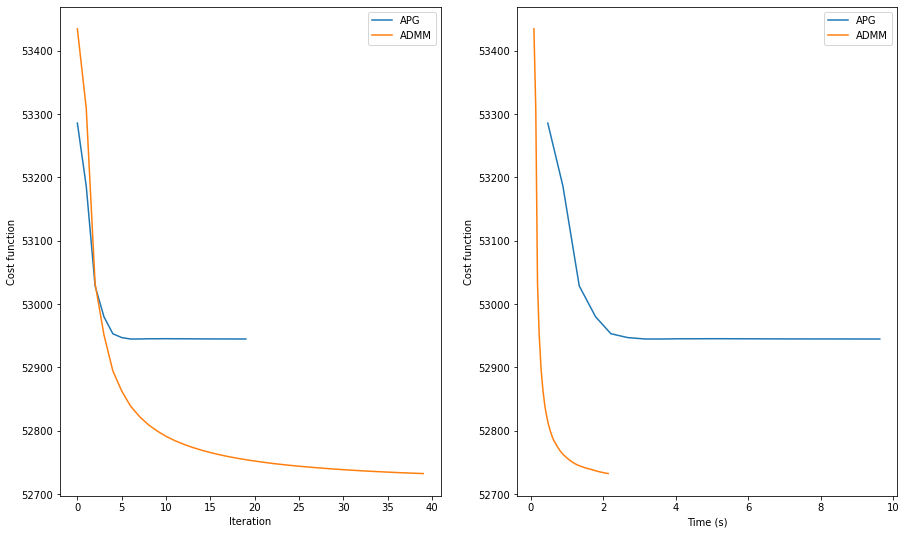

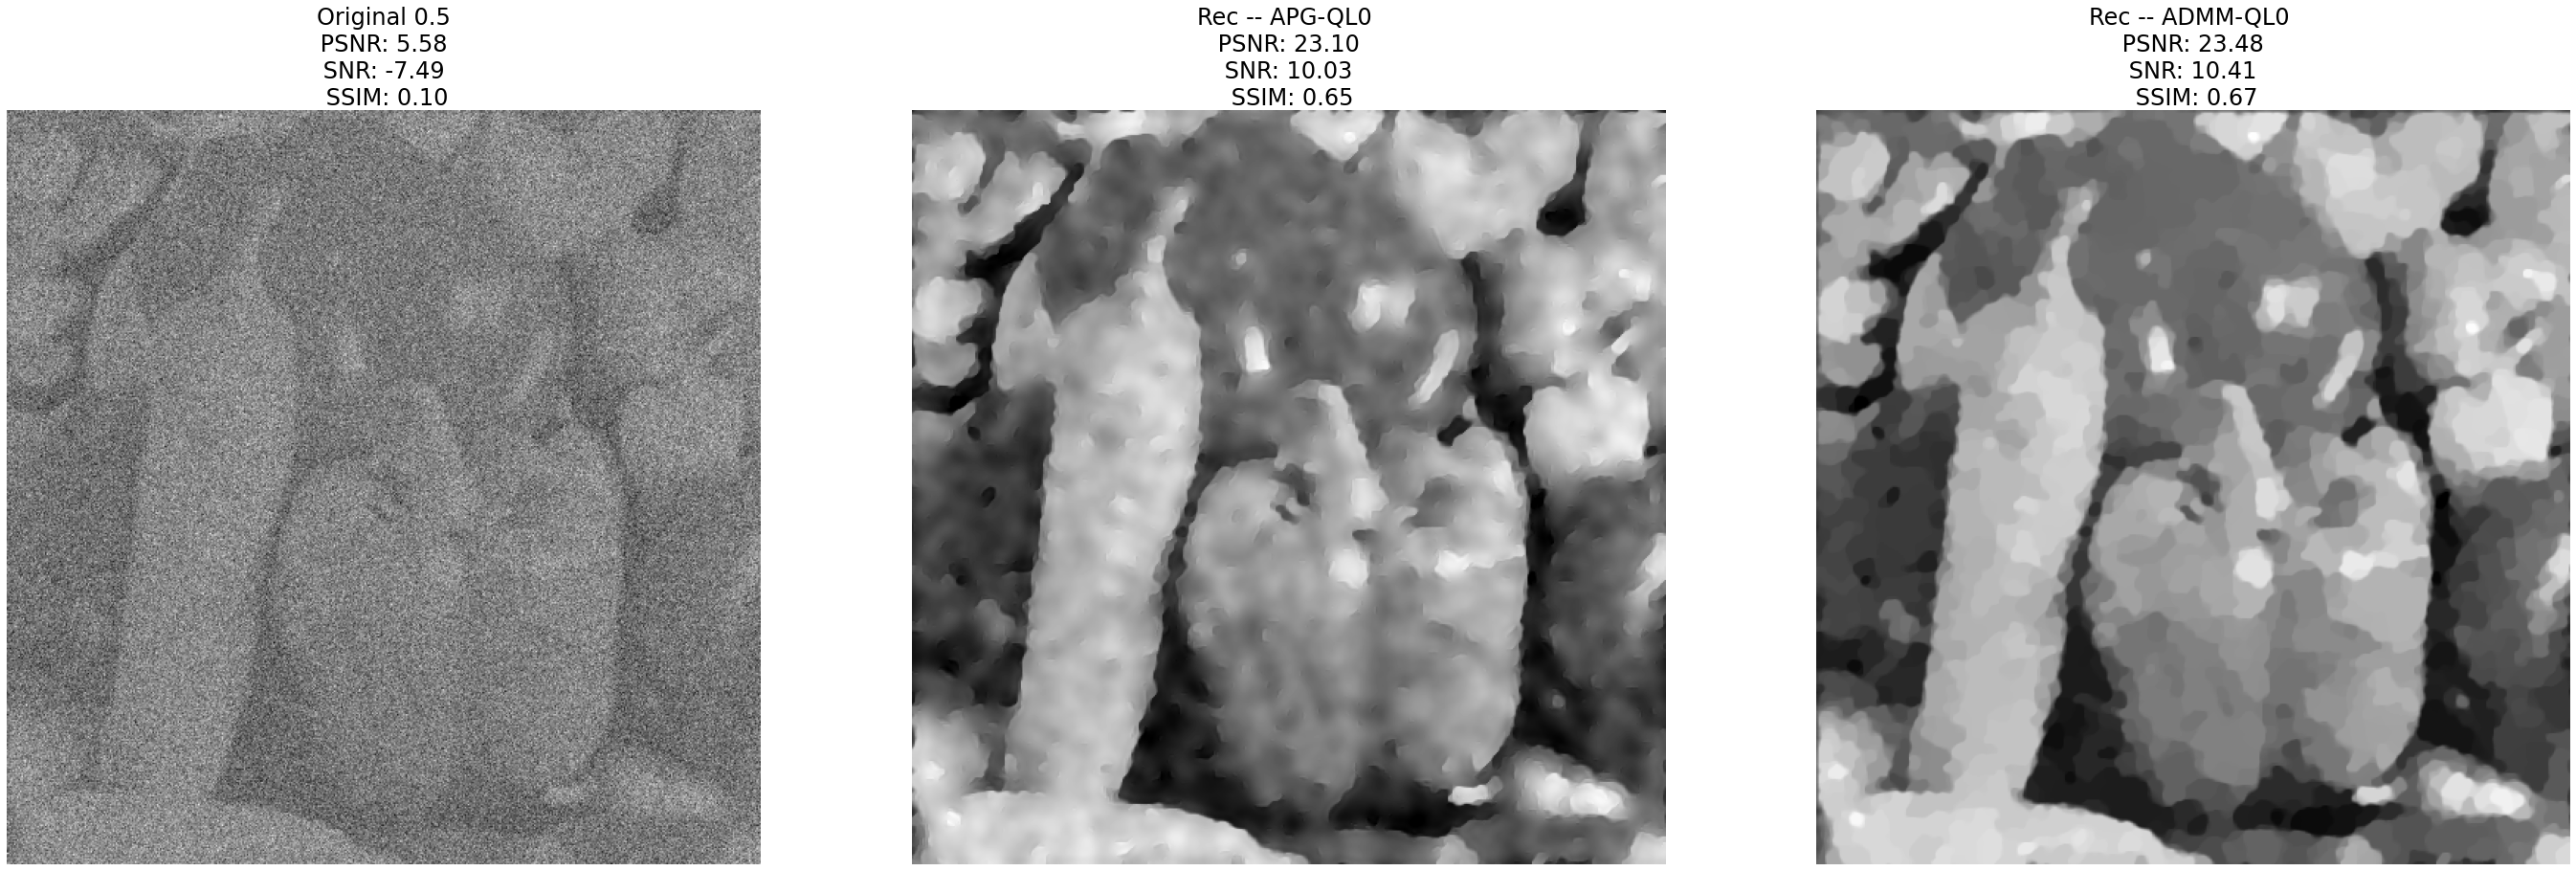

In [65]:
#sigma
j=4
#image
k=3

sigmas=[0.0, 0.05,0.1,0.25,0.5]
sigstr=["00","005","01","025","05"]
sig=sigmas[j]
imgBlur=gaussNoise( conv2D(u[k], H[2] ), sig )  
imgRec_Ql0grad, Stats_Ql0grad = fista_l0tv(imgBlur, H[2], A_lmb_Ql0grad_grey[k+j*4], 0.01, nIter=np.array([20,20],dtype=int), beta=1./8., flagSymm=True, flagPCost=False) 
imgRec_Ql0grad_admm, Stats_Ql0grad_admm = admmql0(imgBlur, H[2], A_lmb_Ql0grad_grey[k+j*4], 0.01,40, rhoFactor=20, relax=1.5, flagPCost=False, flagSymm=True) 
# k=k-4
# imgRec_Ql0grad, Stats_Ql0grad = fista_l0tv(imgBlur, H[2], C_A_lmb_Ql0grad_grey[k+j*4], 0.04, nIter=np.array([20,20],dtype=int), beta=1./8., flagSymm=True, flagPCost=False) 
# imgRec_Ql0grad_admm, Stats_Ql0grad_admm = admmql0(imgBlur, H[2], C_A_lmb_Ql0grad_grey[k+j*4], 0.04,40, rhoFactor=20, relax=1.5, flagPCost=False, flagSymm=True) 


#admmql0(b, H, lmb, gamma , nIter, rhoFactor=10, relax=1.0, flagPCost=True, flagSymm=True):


imgRec_Ql0grad=np.clip(imgRec_Ql0grad,0,1)
imgRec_Ql0grad_admm=np.clip(imgRec_Ql0grad_admm,0,1)

#plot cost function

# k=k+4

# Plot TV-fCost
figure, f = PLT.subplots(ncols=2, figsize=(15, 9))

f[0].plot(Stats_Ql0grad[:,0], Stats_Ql0grad[:,1],label="APG")
f[0].plot(Stats_Ql0grad_admm[:,0], Stats_Ql0grad_admm[:,1],label="ADMM")
f[0].legend(loc='upper right')
PLT.setp(f[0], xlabel='Iteration',ylabel='Cost function')

f[1].plot(Stats_Ql0grad[:,4], Stats_Ql0grad[:,1],label="APG")
f[1].plot(Stats_Ql0grad_admm[:,4], Stats_Ql0grad_admm[:,1],label="ADMM")
f[1].legend(loc='upper right')
PLT.setp(f[1], xlabel='Time (s)',ylabel='Cost function')
# PLT.savefig("./comparison_admm_apg/"+Names[k]+"004ave.svg")

PLT.show()


metrics_TV = []

metrics_TV.append( psnr(u[k], imgBlur) )
metrics_TV.append(  snr(u[k], imgBlur) )
metrics_TV.append( ssim(u[k], imgBlur) )

metrics_TV.append( psnr(u[k], imgRec_Ql0grad) )
metrics_TV.append(  snr(u[k], imgRec_Ql0grad) )
metrics_TV.append( ssim(u[k], imgRec_Ql0grad) )

metrics_TV.append( psnr(u[k], imgRec_Ql0grad_admm) )
metrics_TV.append(  snr(u[k], imgRec_Ql0grad_admm) )
metrics_TV.append( ssim(u[k], imgRec_Ql0grad_admm) )


                  
# \n PSNR: {:01.2f} \n SNR: {:01.2f} \n MSE: {:01.2g} \n SSIM: {:01.2f}'.format(metrics_TV[4],metrics_TV[5],metrics_TV[6],metrics_TV[7]))
                  

txtN = []
txtN.append('Original '+str(sig)+'\n PSNR: {:01.2f} \n SNR: {:01.2f} \n SSIM: {:01.2f}'.format(metrics_TV[0],metrics_TV[1],metrics_TV[2]))
txtN.append('Rec -- APG-QL0 \n PSNR: {:01.2f} \n SNR: {:01.2f} \n SSIM: {:01.2f}'.format(metrics_TV[3],metrics_TV[4],metrics_TV[5]))
txtN.append('Rec -- ADMM-QL0 \n PSNR: {:01.2f} \n SNR: {:01.2f} \n SSIM: {:01.2f}'.format(metrics_TV[6],metrics_TV[7],metrics_TV[8]))


imgShow = []
imgShow.append(imgBlur)
imgShow.append(imgRec_Ql0grad)
imgShow.append(imgRec_Ql0grad_admm)



plotNImgs(imgShow, 3, txtN)   

# saveImg(imgBlur,"./comparison_admm_apg/"+Names[k]+sigstr[j]+"ave.png")
# saveImg(imgRec_Ql0grad,"./comparison_admm_apg/"+Names[k]+sigstr[j]+"004aveapg.png")
# saveImg(imgRec_Ql0grad_admm,"./comparison_admm_apg/"+Names[k]+sigstr[j]+"004aveadmm.png")


## Gaussian filter

In [8]:
G_lmb_Ql0grad_grey=[0.014444444444444446,0.017361111111111112,0.007916666666666667,0.022083333333333333,
                   0.020833333333333332,0.028888888888888888,0.012222222222222223,0.0325,
                   0.0525,0.06562500000000002,0.023125000000000003,0.07875,
                   0.49479166666666663,0.6041666666666667,0.3177083333333335,0.6041666666666667,
                   2.815972222222222,2.9548611111111107,2.954861111111111,2.954861111111111]
C_G_lmb_Ql0grad_grey=[0.018055555555555557,0.011805555555555555,0.007291666666666666,0.020833333333333336,
                     0.026250000000000002,0.0221875,0.010625,0.027812500000000004,
                     0.052500000000000005,0.0575,0.023125000000000003,0.06562500000000002,
                     0.527777777777778,0.5083333333333335,0.30416666666666664,0.5569444444444446,
                     2.944444444444444,2.763888888888889,2.763888888888889,2.944444444444444]

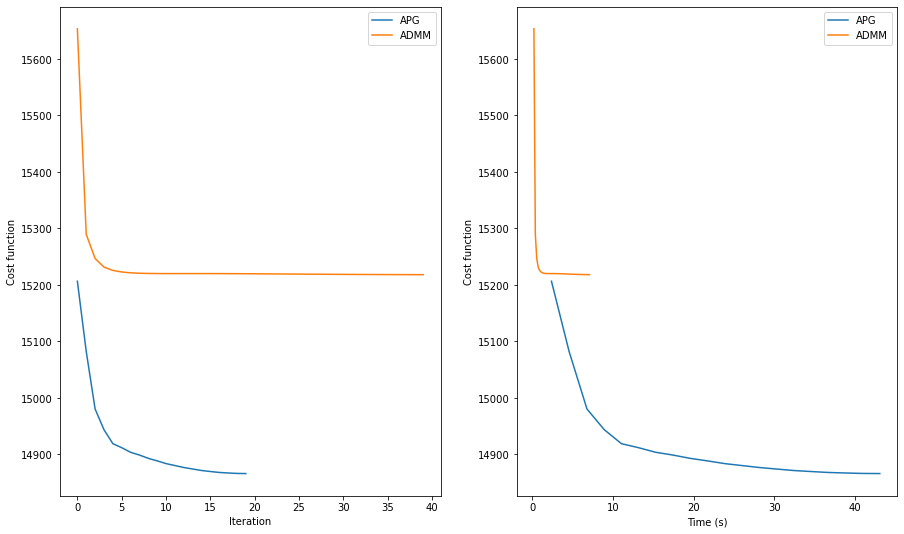

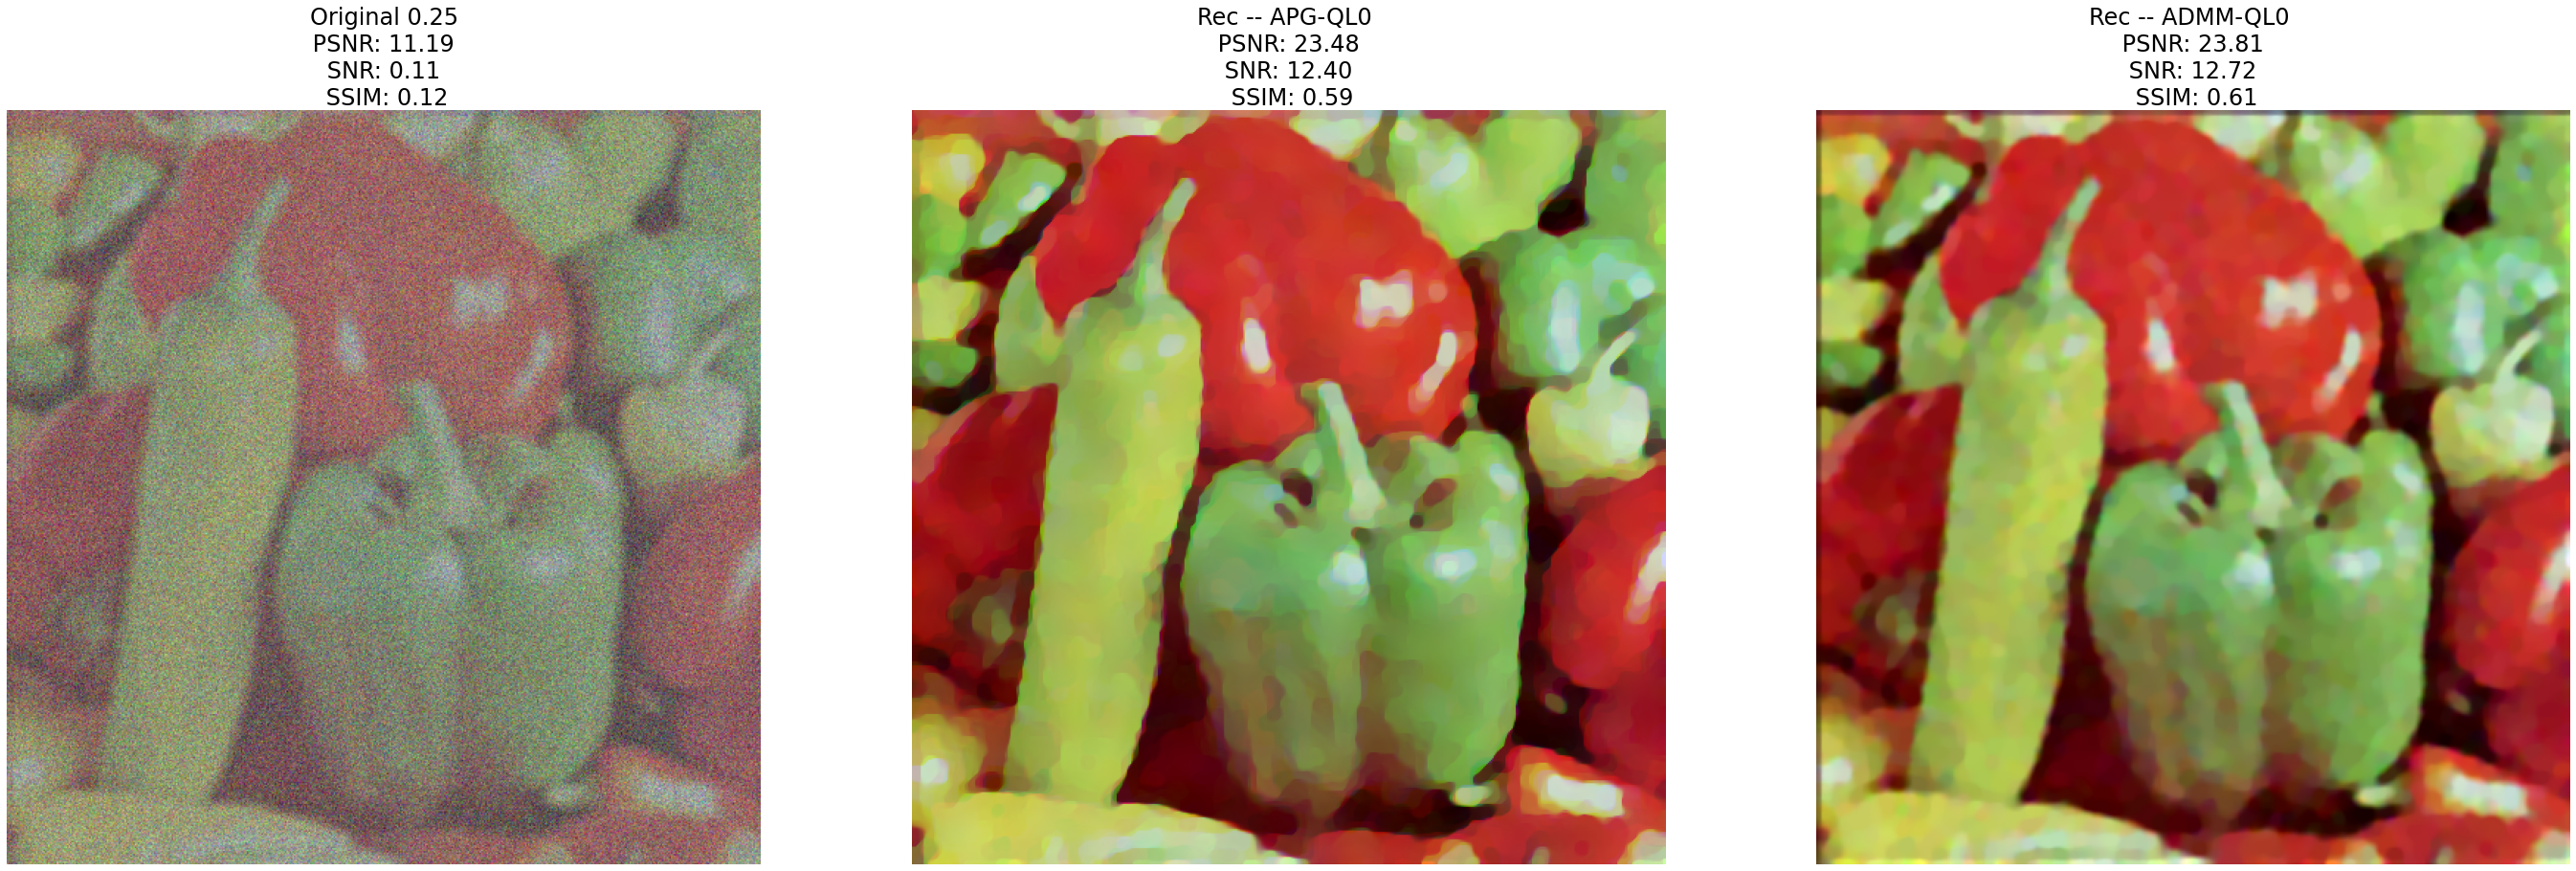

In [10]:
#sigma
j=3
#image
k=7

sigmas=[0.0,0.05,0.1,0.25,0.5]
sigstr=["00","005","01","025","05"]
sig=sigmas[j]
# imgBlur=gaussNoise( conv2D(u[k], H[1] ), sig )  
# imgRec_Ql0grad, Stats_Ql0grad = fista_l0tv(imgBlur, H[1], G_lmb_Ql0grad_grey[k+j*4], 0.01, nIter=np.array([20,30],dtype=int), beta=1./8., flagSymm=True, flagPCost=False) 
# imgRec_Ql0grad_admm, Stats_Ql0grad_admm = admmql0(imgBlur, H[1], G_lmb_Ql0grad_grey[k+j*4], 0.01,40, rhoFactor=20, relax=1.5, flagPCost=False, flagSymm=True) 

k=k-4

imgRec_Ql0grad, Stats_Ql0grad = fista_l0tv(imgBlur, H[1], C_G_lmb_Ql0grad_grey[k+j*4], 0.01, nIter=np.array([20,30],dtype=int), beta=1./8., flagSymm=True, flagPCost=False) 
imgRec_Ql0grad_admm, Stats_Ql0grad_admm = admmql0(imgBlur, H[1], C_G_lmb_Ql0grad_grey[k+j*4], 0.01,40, rhoFactor=20, relax=1.5, flagPCost=False, flagSymm=True) 



imgRec_Ql0grad=np.clip(imgRec_Ql0grad,0,1)
imgRec_Ql0grad_admm=np.clip(imgRec_Ql0grad_admm,0,1)

#plot cost function
k=k+4

# Plot TV-fCost
figure, f = PLT.subplots(ncols=2, figsize=(15, 9))

f[0].plot(Stats_Ql0grad[:,0], Stats_Ql0grad[:,1],label="APG")
f[0].plot(Stats_Ql0grad_admm[:,0], Stats_Ql0grad_admm[:,1],label="ADMM")
f[0].legend(loc='upper right')
PLT.setp(f[0], xlabel='Iteration',ylabel='Cost function')

f[1].plot(Stats_Ql0grad[:,4], Stats_Ql0grad[:,1],label="APG")
f[1].plot(Stats_Ql0grad_admm[:,4], Stats_Ql0grad_admm[:,1],label="ADMM")
f[1].legend(loc='upper right')
PLT.setp(f[1], xlabel='Time (s)',ylabel='Cost function')

# print ("Time in APG= "+str(Stats_Ql0grad[19,4])+"\n")
# print ("Time in APG= "+str(Stats_Ql0grad_admm[39,4]))

PLT.savefig("./comparison_admm_apg/"+Names[k]+"001gaus.svg")
PLT.show()

metrics_TV = []

metrics_TV.append( psnr(u[k], imgBlur) )
metrics_TV.append(  snr(u[k], imgBlur) )
metrics_TV.append( ssim(u[k], imgBlur) )

metrics_TV.append( psnr(u[k], imgRec_Ql0grad) )
metrics_TV.append(  snr(u[k], imgRec_Ql0grad) )
metrics_TV.append( ssim(u[k], imgRec_Ql0grad) )

metrics_TV.append( psnr(u[k], imgRec_Ql0grad_admm) )
metrics_TV.append(  snr(u[k], imgRec_Ql0grad_admm) )
metrics_TV.append( ssim(u[k], imgRec_Ql0grad_admm) )


                  
# \n PSNR: {:01.2f} \n SNR: {:01.2f} \n MSE: {:01.2g} \n SSIM: {:01.2f}'.format(metrics_TV[4],metrics_TV[5],metrics_TV[6],metrics_TV[7]))
                  

txtN = []
txtN.append('Original '+str(sig)+'\n PSNR: {:01.2f} \n SNR: {:01.2f} \n SSIM: {:01.2f}'.format(metrics_TV[0],metrics_TV[1],metrics_TV[2]))
txtN.append('Rec -- APG-QL0 \n PSNR: {:01.2f} \n SNR: {:01.2f} \n SSIM: {:01.2f}'.format(metrics_TV[3],metrics_TV[4],metrics_TV[5]))
txtN.append('Rec -- ADMM-QL0 \n PSNR: {:01.2f} \n SNR: {:01.2f} \n SSIM: {:01.2f}'.format(metrics_TV[6],metrics_TV[7],metrics_TV[8]))


imgShow = []
imgShow.append(imgBlur)
imgShow.append(imgRec_Ql0grad)
imgShow.append(imgRec_Ql0grad_admm)



plotNImgs(imgShow, 3, txtN)  

# saveImg(imgBlur,"./comparison_admm_apg/"+Names[k]+sigstr[j]+"gaus.png")
saveImg(imgRec_Ql0grad,"./comparison_admm_apg/"+Names[k]+sigstr[j]+"001gausapg.png")
saveImg(imgRec_Ql0grad_admm,"./comparison_admm_apg/"+Names[k]+sigstr[j]+"001gausadmm.png")

## Comparisons greyscale

### denoising

In [13]:
lmb_Ql0grad_grey=[0.06874999999999999,0.031249999999999993,0.021250000000000005,0.07687500000000001,
                 0.19833333333333333,0.18916666666666668,0.15000000000000002,0.19833333333333333,
                 3.0972222222222223,2.5555555555555554,1.902777777777778,3.138888888888889,
                 14.472222222222221,14.180555555555555,14.069444444444445,14.763888888888888]

print("denoising greyscale\n\n")
tests=10
#identity gresyscale
lsigmas=4
limg=4
names=["lena", "barbara", "mandrill", "peppers"]
sigmas=[0.05,0.1,0.25,0.5]
#results=np.zeros((5,4,9), dtype=float)
for j in range (lsigmas):
    sig=sigmas[j]
    for k in range(limg):
        mPSNR_Ql0grad=[]
        mSNR_Ql0grad=[]
        mSSIM_Ql0grad=[]
        time_Ql0grad=[]
        
                
        for m in range(tests):
            imgBlur=gaussNoise( conv2D(u[k], H[0] ), sig ) 
            imgRec_Ql0grad, Stats_Ql0grad = admmql0(imgBlur, H[0], lmb_Ql0grad_grey[k+j*4], 0.01,40, rhoFactor=20, relax=1.5, flagPCost=False, flagSymm=True) 

            imgRec_Ql0grad=np.clip(imgRec_Ql0grad,0,1)
            
            #PSNR
            mPSNR_Ql0grad.append(psnr(u[k],imgRec_Ql0grad))
            
            #SNR
            mSNR_Ql0grad.append(snr(u[k],imgRec_Ql0grad))
            
            #SSIM
            mSSIM_Ql0grad.append(ssim(u[k],imgRec_Ql0grad))
            
            #time
            time_Ql0grad.append(Stats_Ql0grad[39,4])
            
        print(str(names[k])+" sigma="+str(sig))
        print(" ")
        print("Ql0grad")
        print("PSNR average: "+str(np.average(mPSNR_Ql0grad)))
        print("PSNR standard deviation: "+str(np.std(mPSNR_Ql0grad)))
        print("SNR average: "+str(np.average(mSNR_Ql0grad)))
        print("SNR standard deviation: "+str(np.std(mSNR_Ql0grad)))
        print("SSIM average: "+str(np.average(mSSIM_Ql0grad)))
        print("SSIM standard deviation: "+str(np.std(mSSIM_Ql0grad)))
        print("time average: "+str(np.average(time_Ql0grad)))
        print("time standard deviation: "+str(np.std(time_Ql0grad)))                              
        print(" ")
        print(" ")

denoising greyscale


lena sigma=0.05
 
Ql0grad
PSNR average: 31.72465196128776
PSNR standard deviation: 0.01954963229248602
SNR average: 18.450553557361825
SNR standard deviation: 0.019549632292484746
SSIM average: 0.8544009543154203
SSIM standard deviation: 0.0017121633865136577
time average: 1.67308197739967
time standard deviation: 0.06525217817326813
 
 
barbara sigma=0.05
 
Ql0grad
PSNR average: 27.23004504165151
PSNR standard deviation: 0.011163659323463472
SNR average: 14.590796911536913
SNR standard deviation: 0.011163659323463129
SSIM average: 0.8230218974303339
SSIM standard deviation: 0.0023703931112628363
time average: 1.597103603299729
time standard deviation: 0.04282102859910738
 
 
mandrill sigma=0.05
 
Ql0grad
PSNR average: 25.982355047861383
PSNR standard deviation: 0.008667451313614582
SNR average: 11.243948318080424
SNR standard deviation: 0.008667451313615177
SSIM average: 0.8364232615025099
SSIM standard deviation: 0.0012373841117118002
time average: 1.56637282369

### average

In [14]:
A_lmb_Ql0grad_grey=[0.01875,0.0221875,0.008124999999999995,0.026250000000000002,
                   0.029479166666666667,0.026875,0.013333333333333338,0.0471875,
                   0.09652777777777775,0.09652777777777777,0.03527777777777779,0.1373611111111111,
                   0.8819444444444444,0.8819444444444445,0.5347222222222222,1.1180555555555556,
                   4.479166666666666,4.645833333333333,4.645833333333333,4.916666666666667]


print("average greyscale\n\n")
tests=10
#identity gresyscale
lsigmas=5
limg=4
names=["lena", "barbara", "mandrill", "peppers"]
sigmas=[0.0,0.05,0.1,0.25,0.5]
#results=np.zeros((5,4,9), dtype=float)
for j in range (lsigmas):
    sig=sigmas[j]
    for k in range(limg):
        mPSNR_Ql0grad=[]
        mSNR_Ql0grad=[]
        mSSIM_Ql0grad=[]
        time_Ql0grad=[]
        
                
        for m in range(tests):
            imgBlur=gaussNoise( conv2D(u[k], H[2] ), sig ) 
            imgRec_Ql0grad, Stats_Ql0grad = admmql0(imgBlur, H[2], A_lmb_Ql0grad_grey[k+j*4], 0.01,40, rhoFactor=20, relax=1.5, flagPCost=False, flagSymm=True) 

            imgRec_Ql0grad=np.clip(imgRec_Ql0grad,0,1)
            
            #PSNR
            mPSNR_Ql0grad.append(psnr(u[k],imgRec_Ql0grad))
            
            #SNR
            mSNR_Ql0grad.append(snr(u[k],imgRec_Ql0grad))
            
            #SSIM
            mSSIM_Ql0grad.append(ssim(u[k],imgRec_Ql0grad))
            
            #time
            time_Ql0grad.append(Stats_Ql0grad[39,4])
            
        print(str(names[k])+" sigma="+str(sig))
        print(" ")
        print("Ql0grad")
        print("PSNR average: "+str(np.average(mPSNR_Ql0grad)))
        print("PSNR standard deviation: "+str(np.std(mPSNR_Ql0grad)))
        print("SNR average: "+str(np.average(mSNR_Ql0grad)))
        print("SNR standard deviation: "+str(np.std(mSNR_Ql0grad)))
        print("SSIM average: "+str(np.average(mSSIM_Ql0grad)))
        print("SSIM standard deviation: "+str(np.std(mSSIM_Ql0grad)))
        print("time average: "+str(np.average(time_Ql0grad)))
        print("time standard deviation: "+str(np.std(time_Ql0grad)))                              
        print(" ")
        print(" ")

average greyscale


lena sigma=0.0
 
Ql0grad
PSNR average: 27.461092948193528
PSNR standard deviation: 3.552713678800501e-15
SNR average: 14.186994544267588
SNR standard deviation: 0.0
SSIM average: 0.7795980535454589
SSIM standard deviation: 0.0
time average: 1.767511771199679
time standard deviation: 0.3061249728481442
 
 
barbara sigma=0.0
 
Ql0grad
PSNR average: 22.73019828420927
PSNR standard deviation: 3.552713678800501e-15
SNR average: 10.09095015409467
SNR standard deviation: 0.0
SSIM average: 0.6573362402362075
SSIM standard deviation: 0.0
time average: 1.6632599345999552
time standard deviation: 0.004473390648642402
 
 
mandrill sigma=0.0
 
Ql0grad
PSNR average: 20.379927854222224
PSNR standard deviation: 3.552713678800501e-15
SNR average: 5.641521124441276
SNR standard deviation: 0.0
SSIM average: 0.4977470708622631
SSIM standard deviation: 0.0
time average: 1.671081991200299
time standard deviation: 0.004684818424035575
 
 
peppers sigma=0.0
 
Ql0grad
PSNR average: 29.71458

### Gaussian 

In [15]:
G_lmb_Ql0grad_grey=[0.014444444444444446,0.017361111111111112,0.007916666666666667,0.022083333333333333,
                   0.020833333333333332,0.028888888888888888,0.012222222222222223,0.0325,
                   0.0525,0.06562500000000002,0.023125000000000003,0.07875,
                   0.49479166666666663,0.6041666666666667,0.3177083333333335,0.6041666666666667,
                   2.815972222222222,2.9548611111111107,2.954861111111111,2.954861111111111]

print("gaussian greyscale\n\n")
tests=10
#identity gresyscale
lsigmas=5
limg=4
names=["lena", "barbara", "mandrill", "peppers"]
sigmas=[0.0,0.05,0.1,0.25,0.5]
#results=np.zeros((5,4,9), dtype=float)
for j in range (lsigmas):
    sig=sigmas[j]
    for k in range(limg):
        mPSNR_Ql0grad=[]
        mSNR_Ql0grad=[]
        mSSIM_Ql0grad=[]
        time_Ql0grad=[]
        
                
        for m in range(tests):
            imgBlur=gaussNoise( conv2D(u[k], H[1] ), sig ) 
            imgRec_Ql0grad, Stats_Ql0grad = admmql0(imgBlur, H[1], A_lmb_Ql0grad_grey[k+j*4], 0.01,40, rhoFactor=20, relax=1.5, flagPCost=False, flagSymm=True) 

            imgRec_Ql0grad=np.clip(imgRec_Ql0grad,0,1)
            
            #PSNR
            mPSNR_Ql0grad.append(psnr(u[k],imgRec_Ql0grad))
            
            #SNR
            mSNR_Ql0grad.append(snr(u[k],imgRec_Ql0grad))
            
            #SSIM
            mSSIM_Ql0grad.append(ssim(u[k],imgRec_Ql0grad))
            
            #time
            time_Ql0grad.append(Stats_Ql0grad[39,4])
            
        print(str(names[k])+" sigma="+str(sig))
        print(" ")
        print("Ql0grad")
        print("PSNR average: "+str(np.average(mPSNR_Ql0grad)))
        print("PSNR standard deviation: "+str(np.std(mPSNR_Ql0grad)))
        print("SNR average: "+str(np.average(mSNR_Ql0grad)))
        print("SNR standard deviation: "+str(np.std(mSNR_Ql0grad)))
        print("SSIM average: "+str(np.average(mSSIM_Ql0grad)))
        print("SSIM standard deviation: "+str(np.std(mSSIM_Ql0grad)))
        print("time average: "+str(np.average(time_Ql0grad)))
        print("time standard deviation: "+str(np.std(time_Ql0grad)))                              
        print(" ")
        print(" ")

gaussian greyscale


lena sigma=0.0
 
Ql0grad
PSNR average: 25.15444564471715
PSNR standard deviation: 3.552713678800501e-15
SNR average: 11.880347240791206
SNR standard deviation: 0.0
SSIM average: 0.7004135684462376
SSIM standard deviation: 0.0
time average: 1.7603627637998216
time standard deviation: 0.3244372905655106
 
 
barbara sigma=0.0
 
Ql0grad
PSNR average: 21.91136963045121
PSNR standard deviation: 0.0
SNR average: 9.272121500336619
SNR standard deviation: 1.7763568394002505e-15
SSIM average: 0.5888405698037859
SSIM standard deviation: 0.0
time average: 1.6529037259002508
time standard deviation: 0.00723990321031439
 
 
mandrill sigma=0.0
 
Ql0grad
PSNR average: 19.31293548182123
PSNR standard deviation: 0.0
SNR average: 4.574528752040278
SNR standard deviation: 0.0
SSIM average: 0.35438402161228655
SSIM standard deviation: 0.0
time average: 1.6620468308001364
time standard deviation: 0.009139861077960547
 
 
peppers sigma=0.0
 
Ql0grad
PSNR average: 26.250759303132874
PSNR 

In [3]:
shape=np.shape(u[0])

In [4]:
shape

(512, 512)

In [67]:
evs=gaussNoise( conv2D(u[1], H[0] ), 0.25 )  
evs=np.clip(evs,0,1)
0.5*np.sum( ( evs  )**2.0 )

39760.515902352934

In [68]:
bF, symDims = getImg_Fsym(evs, H[0].shape)
bF_norm = 1.5*np.sum( np.abs( bF )**2.0 )/np.float(evs.size)
bF_norm

103490.71677661678

In [80]:
AA=[[1,2,3,4,5],[10,20,30,40,50]]
AA=np.asarray(AA)
print(AA[1,1:])

[20 30 40 50]


In [78]:
np.shape(AA)

(2, 5)